In [14]:
from glampy.sampler import PoissonDiskSampler
from glampy.generator import ArchitectureGenerator

import subprocess
import matplotlib.pyplot as plt

In [15]:
#bac_mass = 0.00000644579089
#bac_num = 1000

mode = 'hybrid' # angle or full or sphere or hybrid
units = 'lj'
atom_types = 1 # == 1 -- all ONE size ; <> 1 -- different sizes
localization = 'ileum'

#seed = 34882 # seed
seed = 42

spacing = 1.5  # spacing number from 0 to 2 (see docs)

x = (0, 40)  # (μm) -> 0.5 cm
y = (0, 40)  # (μm) -> 0.5 cm
z = (0, 40)  # (μm) -> 0.5 cm
# z = None  # if None, then calculated based on the chain(s) length
box_size = (x, y, z)

if localization == 'ileum':
    villus_height = 40  # 1200 # μm
    villus_width = 4  # μm 1 or 4

    min_intervillus_width = 1.5  # μm 4 or 1
    # mean_intervillus_width = 42  # μm

    graft_size = 4  # 1 or 4

    crypt_bottom_height = 4  # 1 or 4
    crypt_bottom_width = 4 # 1 or 4

    crypt_top_height = 4  # 1 or 4
    crypt_top_width = 4  # 1 or 4

    # min_dist = crypt_bottom_width + min_intervillus_width  # 353 μm -- should be revised with UCPH
    min_dist = graft_size + min_intervillus_width
elif localization == 'caecum':
    villus_height = 300  # μm
    villus_width = 100  # μm

    min_intervillus_width = 25  # μm
    # mean_intervillus_width = 42  # μm

    graft_size = 300  # 300

    crypt_bottom_height = 100  # 583 μm
    crypt_bottom_width = 100

    crypt_top_height = 200  # 200
    crypt_top_width = 200  # 200

    min_dist = crypt_bottom_width + min_intervillus_width  # 353 μm -- should be revised with UCPH

graft_mass = 1000
crypt_bottom_mass = 1000
crypt_top_mass = 1000
villus_mass = 1000

n_anchors = 42

bottom_padding = 1

### Initialize architecture generator

In [16]:
archgen = ArchitectureGenerator(box_size, seed, min_dist, n_anchors, units, bottom_padding=bottom_padding, mode=mode)

### Sample villi positions

In [17]:
n_actual = archgen.generate_grafting_layer(n_anchors, 10**6)

In [18]:
if n_actual != n_anchors:
    print(f'Warning: Grafting layer too dense. {n_actual} grafting points instead of {n_anchors}.')
else:
    print(f'{n_actual} points')

42 points


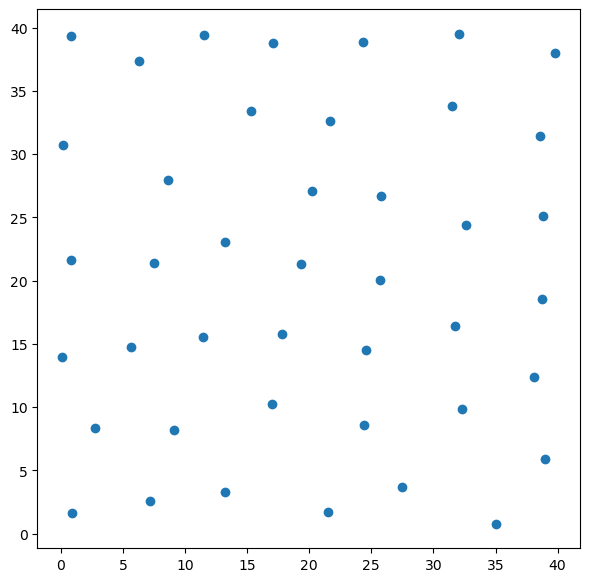

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(archgen.coordinates[:, 0], archgen.coordinates[:, 1])

### Construct brushes

In [20]:
# Construct grafting beads (fixed layer)

archgen.build(spacing=spacing,
                bead_type="graft",
                bead_size=graft_size,
                bead_mass=graft_mass,
                chain_height=graft_size,
                bond_style="fene",
                pair_style="lj/cut")

In [21]:
# Construct villi beads (moving layer)

archgen.build(spacing=spacing,
                bead_type="villi",
                bead_size=villus_width,
                bead_mass=villus_mass,
                chain_height=villus_height,
                bond_style="fene",
                pair_style="lj/cut")

### Sample bacteria positions

In [22]:
box_size

((0, 40), (0, 40), (0, 40))

In [23]:
bacteria_box_size = ((0, 40), (0, 40), (45, 85))
n_bacteria = 20000
bacteria_data = [(3, 0.04, 0.000064), (4, 0.08, 0.000512), (5, 0.12, 0.001728)]
bacteria_data_dict = {3: [0.04, 0.000064], 4: [0.08, 0.000512], 5: [0.12, 0.001728]}
min_bac_dist = max(list(zip(*bacteria_data))[1])

n_bacteria_actual = archgen.generate_bacteria(n_bacteria, min_bac_dist, bacteria_box_size)

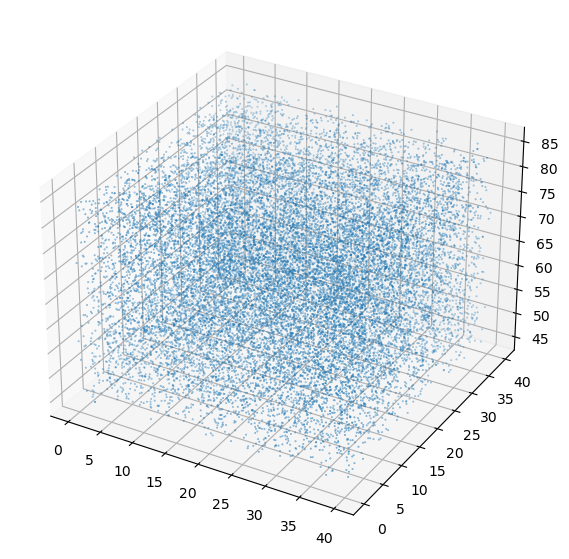

In [24]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d') 
ax.scatter(archgen.coordinates_bacteria[:, 0], archgen.coordinates_bacteria[:, 1], archgen.coordinates_bacteria[:, 2], s=min_bac_dist)
plt.show()

### Construct bacteria

In [25]:
archgen.build(spacing=spacing,
                bead_type="bacteria",
                bead_size=villus_width,
                bead_mass=villus_mass,
                chain_height=villus_height,
                bond_style="fene",
                pair_style="lj/cut", 
                bacteria_data=bacteria_data, 
                bacteria_data_dict=bacteria_data_dict)

### Write architecture in the file

In [26]:
archgen.write("merged.pos")

/Users/nbykov/projects/dev/3D-omics/glampy/glampy/generator.py:368: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  self.atoms.to_csv(f, sep=' ', header=False, index=True, line_terminator='\n', float_format='%.3g')
/Users/nbykov/projects/dev/3D-omics/glampy/glampy/generator.py:374: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  self.bonds.to_csv(f, sep=' ', header=False, index=True, line_terminator='\n', float_format='%.3g')
/Users/nbykov/projects/dev/3D-omics/glampy/glampy/generator.py:378: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  self.angles.to_csv(f, sep=' ', header=False, index=True, line_terminator='\n', float_format='%.3g')


### Run the simulation

In [ ]:
subprocess.run(["mpirun", "-np", "4", "lmp_mpi", "-in", "run.in"])

The output LAMMPS trajectory file (`dump.lammpstrj`) can be visualized using OVITO (see instructions in `INSTALL.md`). Analysis of the trajectory file is planned to be added in the future developments.